In [28]:
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Генерация датасета

sgm - дисперсия гауссова распределения
n - количество точек

In [2]:
sgm=0.5
n=2000
red_dots = numpy.random.multivariate_normal([3, 5, 9], [[sgm,0,0], [0, sgm, 0], [0, 0, sgm]], n)
blue_dots = numpy.random.multivariate_normal([4, 6, 10], [[sgm,0,0], [0, sgm, 0], [0, 0, sgm]], n)
red_dots=numpy.insert(red_dots, 3, 0, axis=1)
blue_dots=numpy.insert(blue_dots, 3, 1, axis=1)
data = numpy.concatenate((red_dots, blue_dots))
numpy.random.shuffle(data)

# Пандасовский датасет

In [4]:
dat = pd.DataFrame({'x' : data[:, 0],
                   'y' : data[:, 1],
                   'z' : data[:, 2], 
                   'class' : data[:, 3]})

In [5]:
dat.head()

,class,x,y,z
0,0,2.283974,5.922023,10.872303
1,0,2.535948,5.749867,9.445232
2,1,3.620386,5.376631,10.831368
3,0,1.622166,5.009647,9.130066
4,1,4.415261,5.196477,10.105817


# Запуск классификатора на данных из датасета

In [7]:
rf = RandomForestClassifier()

In [30]:
rf.fit(dat[['x', 'y', 'z']], dat['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [31]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [44]:
true_y = dat['class']
pred_y = rf.predict_proba(dat[['x', 'y', 'z']])[:, 1]

In [45]:
type(pred_y)

numpy.ndarray

In [46]:
roc_auc_score(true_y, pred_y )

0.99969662500000001

# Трёхмерный рисунок

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


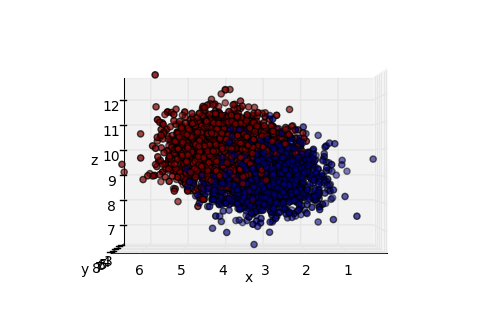

In [86]:
ax=plt.axes(projection='3d')
ax.view_init(0,90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x=data[:, 0]
y=data[:, 1]
z=data[:, 2]
dx=max(x)-min(x)
dy=max(y)-min(y)
dz=max(z)-min(z)
dcommon = max(dx, dy, dz)
mx = (max(x)+min(x))/2
my = (max(y)+min(y))/2
mz = (max(z)+min(z))/2
ax.set_xlim3d((mx-dcommon/2,mx+dcommon/2))
ax.set_ylim3d((my-dcommon/2,my+dcommon/2))
ax.set_zlim3d((mz-dcommon/2,mz+dcommon/2))
ax.scatter(x,y,z, c=data[:, 3])
plt.show()

In [87]:
data.shape

(4000, 4)

In [88]:
w=numpy.array([1,2,3])

In [89]:
n=data.shape[0]
projections=numpy.zeros((n,2))
projections[:,1]=data[:,3]
for t in range(n):
    projections[t,0] = w.dot(data[t,:3])

In [90]:
def make_proj(data, w):
    pr1=data[:,:3].dot(w)
    return numpy.stack((pr1,data[:,3]), axis=1)

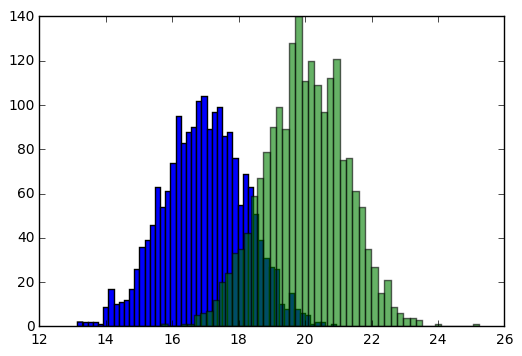

In [129]:
prj=make_proj(data, numpy.array([1, 1, 1]))
plt.hist(prj[prj[:, 1]<0.5][:, 0], 50)
plt.hist(prj[prj[:, 1]>0.5][:, 0], 50, alpha=0.6)
plt.show()

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


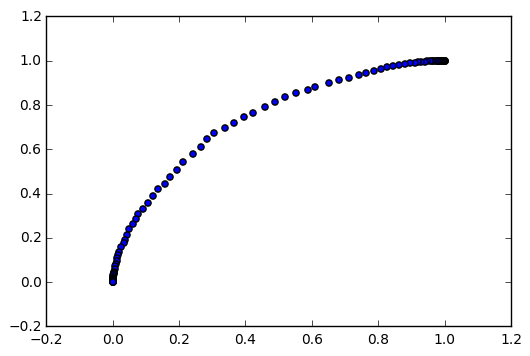

In [127]:
prj=make_proj(data, numpy.array([0.2, -0.5, 1]))
x=[]
y=[]
for thresh in numpy.linspace(numpy.min(prj[:,0]), numpy.max(prj[:, 0]), 100):
    tp = 0
    fp = 0
    den_less = 0
    den_more = 0
    for t in range(n):
        guess = 0
        if prj[t, 0] > thresh:
            guess = 1
        if guess > 0.5 and prj[t, 1] > 0.5:
            tp += 1
        if guess > 0.5 and prj[t, 1] < 0.5:
            fp += 1
        if prj[t, 1] < 0.5:
            den_less += 1
        else:
            den_more += 1
    if den_more > 0 and den_less > 0:
        current_x = fp / den_less
        current_y = tp / den_more
        x.append(current_x)
        y.append(current_y)
plt.scatter(x,y)

# Расчёт Roc-AUC, оптимизация вектора